# Predicting NFL Play Type

My goal is to build a model that will predict whether a team is running or passing the ball based of pre-snap information using supervised learning.

In [ ]:
#data loading
import pandas as pd

#source: https://www.kaggle.com/competitions/nfl-big-data-bowl-2025/data
bf = pd.read_csv('plays.csv')
df = bf.head(1000)
bf = bf.iloc[1000:]

Here I decided to split the data set into 2 datasets. One with the first 1000 rows, in order to train the model. The other with all the remaining rows to test it's accuracy on unseen data.
I decided to only use 1000 rows to train the model so the runtime is not too long.

In [ ]:
#Defining the Target variable
df['isPass'] = df['isDropback'].astype(int)
bf['isPass'] = bf['isDropback'].astype(int)

"isPass" is what I am trying to predict

In [ ]:
#filtering out plays that are not a run or pass
df = df[(df['qbSpike'] != True) & (df['qbKneel'] != 1) & (df['playNullifiedByPenalty'] != 'Y')]
bf = bf[(bf['qbSpike'] != True) & (bf['qbKneel'] != 1) & (bf['playNullifiedByPenalty'] != 'Y')]

In [ ]:
#creating extra variables
# The difference in the score
df['scoreDifferential'] = df.apply(
    lambda x: x['preSnapHomeScore'] - x['preSnapVisitorScore']
    if x['possessionTeam'] == x['yardlineSide']
    else x['preSnapVisitorScore'] - x['preSnapHomeScore'],
    axis=1
)
bf['scoreDifferential'] = bf.apply(
    lambda x: x['preSnapHomeScore'] - x['preSnapVisitorScore']
    if x['possessionTeam'] == x['yardlineSide']
    else x['preSnapVisitorScore'] - x['preSnapHomeScore'],
    axis=1
)

In [ ]:
#convert all nan values in gameClock to 0
df['gameClock'] = df['gameClock'].fillna(0)
bf['gameClock'] = bf['gameClock'].fillna(0)

In [ ]:
#creating a column with the total number of wide receivers
def add_receivers(s):
  """
  Args: The receiverAlignment string
  Returns: The total number of receivers
  """
  parts = s.split("x")
  return int(parts[0]) + int(parts[1])

df['receivers'] = df['receiverAlignment'].apply(add_receivers)
bf['receivers'] = bf['receiverAlignment'].apply(add_receivers)

In [ ]:
#creating another dataset that has each team's passing tendencies
#source: https://www.nfeloapp.com/nfl-power-ratings/nfl-team-tendencies/
nf = pd.read_csv('nfl-team-tendencies.csv')

#changing inconsistencies in the team names
nf['team'][24] = 'LV'
nf['team'][17] = 'LA'
nf.head(5)

<ipython-input-31-c2dce98c87b7>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  nf['team'][24] = 'LV'
<ipython-input-31-c2dce98c87b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

,unique_id,season,team,team_nick,team_name,team_logo_espn,team_color,pass_rate,rush_rate,proe,...,go_fourth,go_two,rec_gini,rush_gini,personnel_gini,formation_gini,play_clock_used,plays_per_minute,avg_top,no_huddle
0,ARI_2024,2024,ARI,Cardinals,Arizona Cardinals,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png,#97233F,0.594568,0.405432,-2.452954,...,0.174757,0.119048,0.765854,0.822967,NaN,NaN,40.0,NaN,29:39,0.103783
1,ATL_2024,2024,ATL,Falcons,Atlanta Falcons,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png,#A71930,0.555452,0.444548,-8.089096,...,0.267241,0.095238,0.795223,0.892640,NaN,NaN,40.0,NaN,29:40,0.146319
2,BAL_2024,2024,BAL,Ravens,Baltimore Ravens,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png,#241773,0.522618,0.477382,-7.518294,...,0.156250,0.046154,0.736597,0.869270,NaN,NaN,40.0,NaN,30:57,0.054860
3,BUF_2024,2024,BUF,Bills,Buffalo Bills,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png,#00338D,0.576119,0.423881,-2.006729,...,0.209524,0.015385,0.668603,0.844576,NaN,NaN,40.0,NaN,29:42,0.063682
4,CAR_2024,2024,CAR,Panthers,Carolina Panthers,https://a.espncdn.com/i/teamlogos/nfl/500-dark...,#0085CA,0.636272,0.363728,-2.215233,...,0.236220,0.078947,0.623713,0.867028,NaN,NaN,40.0,NaN,27:50,0.071935


In [ ]:
#sorting the teams by their passing rate
nf_sorted = nf.sort_values(by='pass_rate')

def rank_team(s):
  """
  Args: The team name
  Returns: The rank of the team in terms of passing rate
  """
  return int(nf_sorted[nf_sorted['team'] == s].index.values[0] + 1)

df['passRate'] = df['possessionTeam'].apply(rank_team)
bf['passRate'] = bf['possessionTeam'].apply(rank_team)

I felt that ranking the teams based off their passing tendancies would help the model be more accurate, rather than assigning each team a random number.

In [ ]:
#giving a nummerical value to each offensive formation
off_forms = []
def get_off_form(s):
  """
  Args: The offensive formation
  Returns: The numerical value of the offensive formation
  """
  if s not in off_forms:
    off_forms.append(s)
  return off_forms.index(s)

df['offenseFormation'] = df['offenseFormation'].apply(get_off_form)
bf['offenseFormation'] = bf['offenseFormation'].apply(get_off_form)

Here I just gave each offensive formation a number because I could not come up with a way to order them in a way that would aid the model.

In [ ]:
#creating a binary variable to determine whether or not a team is in the redzone
def isRedzone(n):
  """
  Args: The absolute yardline number
  Returns: 1 if the play is in the redzone, 0 otherwise
  """
  if n < 20:
    return 1
  else:
    return 0

df['inRedzone'] = df['absoluteYardlineNumber'].apply(isRedzone)
bf['inRedzone'] = bf['absoluteYardlineNumber'].apply(isRedzone)

In [ ]:
df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,isPass,scoreDifferential,receivers,passRate,inRedzone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,NaN,NaN,0,Cover-3,Zone,1,18,5,7,0
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,NaN,NaN,0,Quarters,Zone,1,0,5,7,1
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,NaN,NaN,0,Quarters,Zone,1,-14,4,13,0
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,NaN,NaN,0,Quarters,Zone,1,0,4,16,0
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,MAN,READ OPTION,0,Cover-1,Man,0,0,4,3,0


In [ ]:
#take care of missing variables
df = df.dropna(subset=['isPass'])
bf = bf.dropna(subset=['isPass'])

In [ ]:
#preprocessing information
from sklearn.preprocessing import StandardScaler

feat = ['down', 'yardsToGo', 'inRedzone', 'scoreDifferential', 'gameClock', 'receivers', 'passRate', 'offenseFormation']

scaler = StandardScaler()
def convert_to_seconds(time_str):
    """
    Args: The time string
    Returns: The time in seconds
    """
    if isinstance(time_str, str) and ':' in time_str:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    # If already numeric or invalid format, return as is
    return time_str
df['gameClock'] = df['gameClock'].apply(convert_to_seconds)
bf['gameClock'] = bf['gameClock'].apply(convert_to_seconds)

df[feat] = scaler.fit_transform(df[feat])
bf[feat] = scaler.transform(bf[feat])

Here I scaled all the features to make the model more accurate by allowing each feature to have equal influence.

In [ ]:
df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,isPass,scoreDifferential,receivers,passRate,inRedzone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,-0.957222,0.437736,CIN,ATL,CIN,21,...,NaN,NaN,0,Cover-3,Zone,1,2.038903,2.189779,-0.991296,-0.192961
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,-0.957222,0.437736,CIN,DAL,CIN,8,...,NaN,NaN,0,Quarters,Zone,1,0.031230,2.189779,-0.991296,5.182388
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,1.445072,0.960445,HOU,TEN,HOU,20,...,NaN,NaN,0,Quarters,Zone,1,-1.530292,0.179389,-0.349734,-0.192961
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,0.243925,0.437736,KC,TEN,TEN,23,...,NaN,NaN,0,Quarters,Zone,1,0.031230,0.179389,-0.028953,-0.192961
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,0.243925,-0.084974,BAL,TB,TB,27,...,MAN,READ OPTION,0,Cover-1,Man,0,0.031230,0.179389,-1.419004,-0.192961


In [ ]:
from itertools import combinations

def get_subsets(li):
  """
  Args: The list of features
  Returns: All possible subsets of the list
  """
  result = []
  n = len(li)

  # Generate combinations of all lengths from 1 to n-1
  for length in range(1, n):
      for combo in combinations(li, length):
          result.append(list(combo))

  return result

I wanted to test all the different combinations of features to find the most accurate model. So I made a list of all subsets of the features I wanted to test.

['down']
['yardsToGo']
['inRedzone']
['scoreDifferential']
['gameClock']
['receivers']
['passRate']
['offenseFormation']
['down', 'yardsToGo']
['down', 'inRedzone']
['down', 'scoreDifferential']
['down', 'gameClock']
['down', 'receivers']
['down', 'passRate']
['down', 'offenseFormation']
['yardsToGo', 'inRedzone']
['yardsToGo', 'scoreDifferential']
['yardsToGo', 'gameClock']
['yardsToGo', 'receivers']
['yardsToGo', 'passRate']
['yardsToGo', 'offenseFormation']
['inRedzone', 'scoreDifferential']
['inRedzone', 'gameClock']
['inRedzone', 'receivers']
['inRedzone', 'passRate']
['inRedzone', 'offenseFormation']
['scoreDifferential', 'gameClock']
['scoreDifferential', 'receivers']
['scoreDifferential', 'passRate']
['scoreDifferential', 'offenseFormation']
['gameClock', 'receivers']
['gameClock', 'passRate']
['gameClock', 'offenseFormation']
['receivers', 'passRate']
['receivers', 'offenseFormation']
['passRate', 'offenseFormation']
['down', 'yardsToGo', 'inRedzone']
['down', 'yardsToGo', 'sc

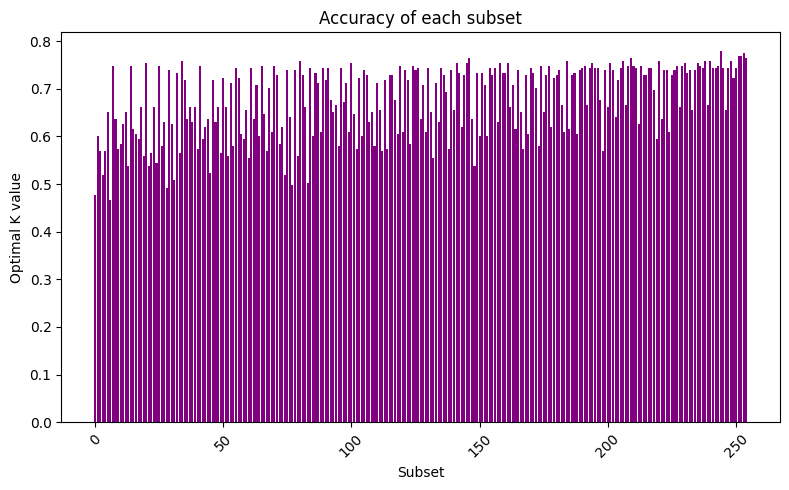

The most accurate subset of variables: ['yardsToGo', 'scoreDifferential', 'gameClock', 'receivers', 'passRate', 'offenseFormation']
The most accurate k value: 10
The accuracy of the model: 0.7794871794871795


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

opt = []
acc_list = []
var = get_subsets(feat)
var.append(feat)
#establishing X and y
for i in var:
  print(i)
  X = df[i]
  y = df['isPass']

  X_indexed = X.reset_index(drop=True)
  y_indexed = y.reset_index(drop=True)

  X_clean = X_indexed.dropna()
  y_clean = y_indexed[X_indexed.index.isin(X_clean.index)]

  X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

  knn = KNeighborsClassifier(n_neighbors=15)
  knn.fit(X_train, y_train)

  k_values = range(1, 16)
  accuracies = []

  for k in k_values:
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(X_train, y_train)
      y_pred_k = knn.predict(X_test)
      acc = accuracy_score(y_test, y_pred_k)
      accuracies.append(acc)

  optimal_k = k_values[accuracies.index(max(accuracies))]
  opt.append(optimal_k)
  acc_list.append(max(accuracies))

subs = []
for i in range(len(var)):
  subs.append(i)

plt.figure(figsize=(8, 5))
plt.bar(subs, acc_list, color='purple')
plt.title('Accuracy of each subset')
plt.xlabel('Subset')
plt.ylabel('Optimal K value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

a = var[acc_list.index(max(acc_list))]
print(f'The most accurate subset of variables: {a}')
print(f'The most accurate k value: {opt[acc_list.index(max(acc_list))]}')
print(f'The accuracy of the model: {max(acc_list)}')

# Bar Graph Explained

This bar graph depicts the accuracies of the models made with each subset of the testable features. Each subset was plugged into X and then cleaned, trained, and tested to make a knn model. The most accurate score of each model gets stored in a list, the same goes for each model's optimal k value. A bar graph is then made using the list of subsets on the x-axis, and their corresponding max accuracies on the y-axis.

By looking at the graph we can see that a lot of the subsets resulted in a solid accuracy of above 70% while some resulted in a fairly bad accuracy of below 50%.

From the graph we can gather that it is possible to make a model with an acceptable accuracy score without needing to feed it as many features as possible, as there are models with only one or two features with an accuracy score above 70%. What is more important is what features are being used.

After the graph was made, the highest accuracy overall is taken, and it's index is used to find the corresponding subset, and it's optimal k value. This is where we got the subset with an accuracy of 77.9% as the best model when it comes to predicting the type of play a team is going to run.

Accuracy: 0.7794871794871795


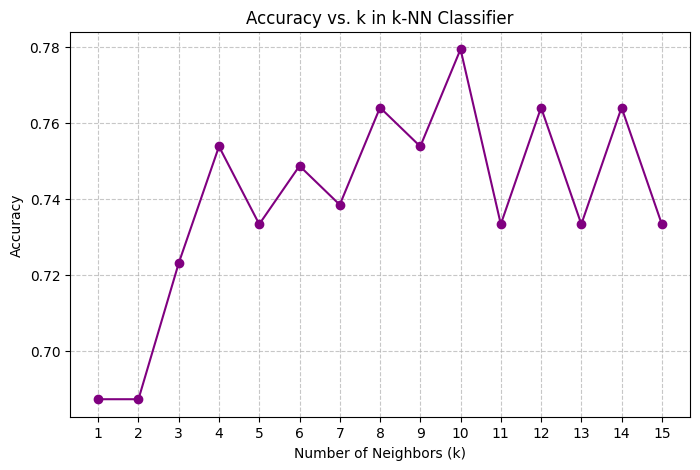

In [ ]:
X = df[a]
y = df['isPass']

X_indexed = X.reset_index(drop=True)
y_indexed = y.reset_index(drop=True)

X_clean = X_indexed.dropna()
y_clean = y_indexed[X_indexed.index.isin(X_clean.index)]

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print(f'Accuracy: {knn.score(X_test, y_test)}')

k_values = range(1, 16)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', color='purple')
plt.title("Accuracy vs. k in k-NN Classifier")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Line Graph Explained

Here the model is set back to the most optimal one. Then the number of neighbors is tested, even though we already know 10 is the optimal value from before, so that the graph can visualize the different accuracies the different number of neighbors result in. The graph shows that a k value of 10 is head and shoulders above the rest of the other numbers, but in general, higher values of k seem to be better than lower values.

In [ ]:
bf.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,isPass,scoreDifferential,receivers,passRate,inRedzone
1000,2022102305,1425,(4:14) D.Henry up the middle to IND 30 for 4 y...,2,-0.957222,0.437736,TEN,IND,IND,34,...,MAN,NaN,0,Cover-3,Zone,0,-1.084143,0.179389,1.574953,-0.192961
1001,2022110300,3274,(3:49) D.Mills scrambles up the middle to PHI ...,4,0.243925,-0.346329,HOU,PHI,PHI,18,...,NaN,NaN,0,Cover-3 Seam,Zone,1,1.369679,0.179389,-0.349734,-0.192961
1002,2022100213,527,(6:50) I.Pacheco left tackle to TB 33 for 8 ya...,1,-0.957222,0.437736,KC,TB,TB,41,...,OUTSIDE ZONE,NaN,0,Cover-1,Man,0,0.477380,0.179389,-0.028953,-0.192961
1004,2022091109,1544,(5:50) (Shotgun) T.Lawrence scrambles left end...,2,-0.957222,0.176381,JAX,WAS,WAS,9,...,NaN,NaN,0,Red Zone,Other,1,-1.195680,0.179389,-0.135880,-0.192961
1005,2022100902,519,(7:36) K.Hunt right guard to LAC 33 for 17 yar...,1,0.243925,-0.084974,CLE,LAC,NaN,50,...,MAN,NaN,0,Cover-3 Seam,Zone,0,-0.749531,0.179389,-0.884369,-0.192961


In [ ]:
from sklearn.impute import SimpleImputer

# Ensure 'a' selects the same columns in both dataframes:
# Assuming 'a' contains the names of the features
# If 'a' contains column indices, adjust accordingly
X = bf[a]
y = bf['isPass']

X_indexed = X.reset_index(drop=True)
y_indexed = y.reset_index(drop=True)

X_clean = X_indexed.dropna()
y_clean = y_indexed[X_indexed.index.isin(X_clean.index)]

new_pred = knn.predict(X_clean)

right = 0
wrong = 0
for i in range(len(bf)):
  if y_clean[i] == new_pred[i]:
    right += 1
  else:
    wrong += 1

print(f'Correct: {right}')
print(f'Wrong: {wrong}')
print(f'Accuracy: {right/(right+wrong)}')

Correct: 10728
Wrong: 4233
Accuracy: 0.7170643673551234


Here I tested the model on all the remaining data from the dataset that it wasn't trained on, to see if it was still accurate when tested against a larger pool of data. It was not as accurate, dropping to an accuracy score of 71.7%, but it is still an acceptable model.

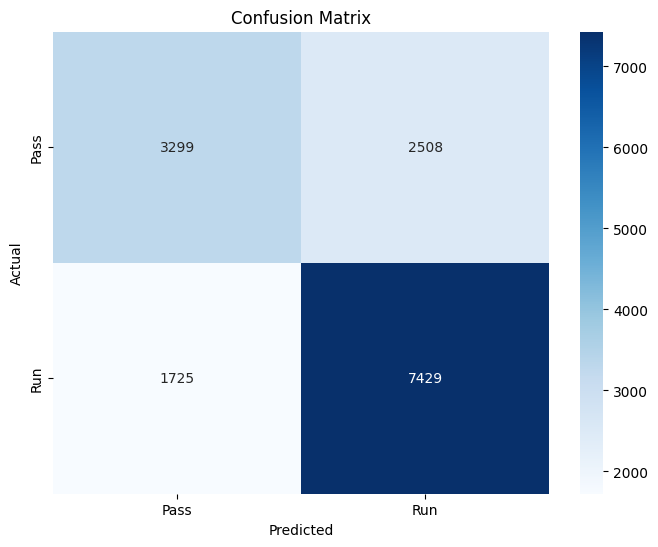

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_clean, new_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pass', 'Run'], yticklabels=['Pass', 'Run'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Confusion Matrix Explained

Looking at this matrix, we can see that out of all the pass plays, the model predicted 3299 correctly and 2508 incorrectly. This means it correctly predicted pass about 66% of the time, identifying roughly 57% of all pass plays. This could be worse but it still is not very accurate. However, it predicted 7429 run plays correctly and only 1725 incorrectly. The model was right 75% of the time when predicting run, correctly identifying 81% of all run plays. The model was significantly better at predicting run plays compared to pass. This shows a large imbalance in the model's performance.